In [176]:
MODULE_PATH = '/Users/anhyojun/WorkSpace/KDT2/MyModule'
import sys
sys.path.append(MODULE_PATH)
from KDTModule import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from konlpy.tag import Okt, Kkma
import spacy
import MeCab

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests
import datetime

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import os

In [2]:
# 시드 고정
torch.manual_seed(1)

## 0. 뉴스 크롤링

#### 일반 뉴스

In [66]:
# 날짜별 뉴스 섹션에서 기사 링크 추출하는 함수 (일반 뉴스)
def article_link_crawling(section_number, date):
    url = f'https://news.naver.com/breakingnews/section/{section_number}/269?date={date}'

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    article = soup.find_all('a', class_='sa_text_title _NLOG_IMPRESSION')

    article_link_list = []
    for i in article:
        article_link_list.append(i['href'])
    
    return article_link_list

# 여러 날짜별 뉴스를 하나의 리스트로 담는 함수
def append_article_list(start_date, end_date, section_number):
    current_date = start_date
    end_date = end_date
    date_difference = (end_date - current_date).days

    total_article_link = []

    for i in range(date_difference+1):
        date = current_date + datetime.timedelta(days=i)
        date_str = date.strftime('%Y%m%d')
        total_article_link += article_link_crawling(section_number, date_str)
    
    return total_article_link

# 네이버 뉴스 섹션별로 기사 링크 txt 파일 생성
section_dict = {100 : 'politics', 101 : 'economy', 102 : 'social', 103 : 'life', 104 : 'world', 105 : 'it'}

for i in section_dict.keys():
    article_link = append_article_list(datetime.date(2024,1,1), datetime.date(2024,10,9),i)
    save_file_name = f"{section_dict[i]}.txt"
    # 크롤링한 링크 저장
    with open(save_file_name, 'w', encoding='utf-8') as f:
        for link in article_link:
            f.write(link + '\n')

#### 스포츠 뉴스 (동적 페이지라 셀레니움 써야함)

In [143]:
# Chrome WebDriver 경로 설정
webdriver_path = '/Users/anhyojun/WebDriver/chromedriver'

# WebDriver 설정 및 실행
service = Service(webdriver_path)
driver = webdriver.Chrome(service=service)

start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 10, 9)
one_day = datetime.timedelta(days=1)
date_difference = (end_date - start_date).days

total_sports_link_list = []

for i in range(date_difference+1):
    for j in range(1, 3):
        date_str = start_date.strftime('%Y%m%d')
        url = f"https://sports.news.naver.com/general/news/index?isphoto=N&date={date_str}&page={j}"

        # 웹페이지 로드
        driver.get(url)
        # 페이지가 로드될 때까지 대기
        time.sleep(1)

        links = driver.find_elements(By.CSS_SELECTOR, 'a.title')
        total_sports_link_list += [link.get_attribute('href') for link in links[:20]]

    start_date += one_day

with open('sports.txt', 'w', encoding='utf-8') as f:
    for link in total_sports_link_list:
        f.write(link + '\n')

#### 연예 뉴스 (동적 페이지라 셀레니움 써야함)

In [152]:
# Chrome WebDriver 경로 설정
webdriver_path = '/Users/anhyojun/WebDriver/chromedriver'

# WebDriver 설정 및 실행
service = Service(webdriver_path)
driver = webdriver.Chrome(service=service)

start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 10, 9)
one_day = datetime.timedelta(days=1)
date_difference = (end_date - start_date).days

total_entertain_link_list = []

for i in range(date_difference+1):
    for j in range(1, 3):
        date_str = start_date.strftime('%Y-%m-%d')
        url = f"https://entertain.naver.com/now#sid=106&date={date_str}&page={j}"

        # 웹페이지 로드
        driver.get(url)
        # 페이지가 로드될 때까지 대기
        time.sleep(1)

        links = driver.find_elements(By.CSS_SELECTOR, 'a.tit')
        total_entertain_link_list += [link.get_attribute('href') for link in links]

    start_date += one_day

with open('entertain.txt', 'w', encoding='utf-8') as f:
    for link in total_entertain_link_list:
        f.write(link + '\n')

#### 링크 목록을 불러와서 뉴스 기사를 텍스트 파일로 저장 (일반 뉴스)

In [195]:
def make_news_txt(section):
    FILE_SAVE_PATH = f'/Users/anhyojun/WorkSpace/LocalData/네이버 뉴스 기사/{section}'

    if not os.path.exists(FILE_SAVE_PATH):
        os.makedirs(FILE_SAVE_PATH)

    with open(f'article_link/{section}.txt', 'r', encoding='utf-8') as f:
        article_link = f.readlines()

    index = 1

    for link in article_link:
        article_url = link.rstrip()
        response = requests.get(article_url)
        article_soup = BeautifulSoup(response.text, 'html.parser')
        try:
            text = article_soup.find('article').text
            with open(f"{FILE_SAVE_PATH}/{section}{index}.txt", 'w', encoding='utf-8') as f:
                f.write(text)
            index += 1
        except:
            pass

In [196]:
make_news_txt('economy')

#### 링크 목록을 불러와서 뉴스 기사를 텍스트 파일로 저장 (연예, 스포츠 뉴스) - 동적 크롤링

In [234]:
def make_news_txt2(section):
    FILE_SAVE_PATH = f'/Users/anhyojun/WorkSpace/LocalData/네이버 뉴스 기사/{section}'

    webdriver_path = '/Users/anhyojun/WebDriver/chromedriver'
    service = Service(webdriver_path)
    driver = webdriver.Chrome(service=service)

    if not os.path.exists(FILE_SAVE_PATH):
        os.makedirs(FILE_SAVE_PATH)

    with open(f'article_link/{section}.txt', 'r', encoding='utf-8') as f:
        article_link = f.readlines()

    index = 1

    for link in article_link:
        article_url = link.rstrip()

        # 셀레니움으로 html 동적 크롤링
        driver.get(article_url)
        time.sleep(1)
        html = driver.page_source

        # BeautifulSoup로 html 파싱
        soup = BeautifulSoup(html, 'html.parser')

        try:
            text = soup.find('div', class_='_article_content').text
            with open(f"{FILE_SAVE_PATH}/{section}{index}.txt", 'w', encoding='utf-8') as f:
                f.write(text)
            index += 1
        except:
            pass

    driver.close()

In [ ]:
make_news_txt2('entertain')

## 1. 데이터 준비

In [3]:
# 폴더에서 txt 불러와서 리스트에 모두 넣기
PATH = '/Users/anhyojun/WorkSpace/LocalData/[자연어처리] 텍스트 분류 모델 구현 - Dataset'
texts_list = []
labels_list = []
for i in range(8): # 0~7까지
    for j in range(200): # 0~199까지
        with open(PATH+f'/{i}/{i}{j:03}NewsData.txt', 'r', encoding='utf-8') as f:
            texts = f.readlines()
            clean_texts = ''.join(texts).replace('\n', '').replace('\t', ' ')
            texts_list.append(clean_texts)
            labels_list.append(i)

In [4]:
texts_list[:5], labels_list[:5]

(['동남아 담당\' 北 최희철 부상 베이징 도착…싱가포르행 주목 최 부상, 행선지·방문 목적 질문에는 \'묵묵부답\'(베이징=연합뉴스) 김진방 특파원 = 북한이 북미 정상회담 무산 가능성까지 거론하며 강경한 태도를 보이는 가운데 동남아시아 외교를 담당하는 최희철 북한 외무성 부상이 19일 중국 베이징 서우두(首都) 공항에 모습을 드러냈다.최 부상은 이날 오전 평양발 고려항공 JS151편을 이용해 베이징 서우두 공항에 도착했다.최 부상은 최종 목적지를 묻는 취재진의 질문에 아무런 답변을 하지 않고, 북한 대사관 관계자들과 함께 공항을 빠져나갔다.북미 정상회담을 20여 일 앞둔 상황에서 동남아 외교통인 최 부상이 정상회담 준비 등을 위해 회담 개최 예정지인 싱가포르를 방문할 가능성도 제기되고 있다.최 부상은 지난 3월에도 아세안(ASEAN·동남아시아국가연합) 의장국이기도 한 싱가포르를 방문해 양국관계와 올해 8월 열리는 아세안지역안보포럼(ARF) 의제 등을 논의한 바 있다.또 지난해 북핵 문제를 두고 북미 간 긴장관계가 형성됐을 때도 ARF에 참석해 아세안을 상대로 여론전을 펼쳤다. 북한의 초청으로 비자이 쿠마르 싱 인도 외교부 국무장관이 방북했을 때도 최 부상은 싱 국무장관을 직접 영접하고, 한반도 문제를 논의하기도 했다.베이징 소식통은 "최 부상이 대(對)미 외교담당이 아니기 때문에 싱가포르로 갈 가능성이 큰 것은 아니다"며 "만약 싱가포르에 간다면 정상회담과 관련한 지원 작업 준비 등을 위한 것일 가능성이 크다"고 말했다.',
  '예결위, 추경 막바지 심사 진통…여야 충돌 (서울=연합뉴스) 김남권 기자 = 국회 예산결산특별위원회는 19일 추가경정예산안의 막바지 심사에 돌입했으나 여야 간 이견에 진통을 겪고 있다. 예결위는 이날 오전 8시 소소위원회를 열고 전날까지 심사에서 보류된 사업 53건의 감액 심사를 했다. 여야 4개 교섭단체의 예결위 간사들만 참석하는 소소위는 심사한 지 한 시간 만에 여야 간 충돌로 정회했다. 자유한국당 예결위 간사인 김도읍 의원

In [5]:
# 훈련, 검증, 테스트 분리
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_list, labels_list, test_size=0.2,
                                                                      stratify=labels_list, random_state=42)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2,
                                                                        stratify=train_labels, random_state=42)

print(f"[train] : {len(train_texts)}")
print(f"[valid] : {len(valid_texts)}")
print(f"[test] : {len(test_texts)}")

[train] : 1024
[valid] : 256
[test] : 320


## 2. 단어사전 생성

In [6]:
# 테스트 문장
texts_list[0]

'동남아 담당\' 北 최희철 부상 베이징 도착…싱가포르행 주목 최 부상, 행선지·방문 목적 질문에는 \'묵묵부답\'(베이징=연합뉴스) 김진방 특파원 = 북한이 북미 정상회담 무산 가능성까지 거론하며 강경한 태도를 보이는 가운데 동남아시아 외교를 담당하는 최희철 북한 외무성 부상이 19일 중국 베이징 서우두(首都) 공항에 모습을 드러냈다.최 부상은 이날 오전 평양발 고려항공 JS151편을 이용해 베이징 서우두 공항에 도착했다.최 부상은 최종 목적지를 묻는 취재진의 질문에 아무런 답변을 하지 않고, 북한 대사관 관계자들과 함께 공항을 빠져나갔다.북미 정상회담을 20여 일 앞둔 상황에서 동남아 외교통인 최 부상이 정상회담 준비 등을 위해 회담 개최 예정지인 싱가포르를 방문할 가능성도 제기되고 있다.최 부상은 지난 3월에도 아세안(ASEAN·동남아시아국가연합) 의장국이기도 한 싱가포르를 방문해 양국관계와 올해 8월 열리는 아세안지역안보포럼(ARF) 의제 등을 논의한 바 있다.또 지난해 북핵 문제를 두고 북미 간 긴장관계가 형성됐을 때도 ARF에 참석해 아세안을 상대로 여론전을 펼쳤다. 북한의 초청으로 비자이 쿠마르 싱 인도 외교부 국무장관이 방북했을 때도 최 부상은 싱 국무장관을 직접 영접하고, 한반도 문제를 논의하기도 했다.베이징 소식통은 "최 부상이 대(對)미 외교담당이 아니기 때문에 싱가포르로 갈 가능성이 큰 것은 아니다"며 "만약 싱가포르에 간다면 정상회담과 관련한 지원 작업 준비 등을 위한 것일 가능성이 크다"고 말했다.'

In [7]:
# MeCab 토크나이저
def mecab_tokenizer(text):
    mecab = MeCab.Tagger('-r /opt/homebrew/etc/mecabrc -Owakati')
    return mecab.parse(text).split()

print(mecab_tokenizer(texts_list[0]))

['동남아', '담당', "'", '北', '최희철', '부상', '베이징', '도착', '…', '싱가포르행', '주목', '최', '부상', ',', '행선지', '·', '방문', '목적', '질문에는', "'", '묵묵부답', "'(", '베이징', '=', '연합뉴스', ')', '김진방', '특파원', '=', '북한이', '북미', '정상회담', '무산', '가능성까지', '거론하며', '강경한', '태도를', '보이는', '가운데', '동남아시아', '외교를', '담당하는', '최희철', '북한', '외무성', '부상이', '19', '일', '중국', '베이징', '서우두', '(', '首都', ')', '공항에', '모습을', '드러냈다', '.', '최', '부상은', '이날', '오전', '평양발', '고려항공', 'JS', '151', '편을', '이용해', '베이징', '서우두', '공항에', '도착했다', '.', '최', '부상은', '최종', '목적지를', '묻는', '취재진의', '질문에', '아무런', '답변을', '하지', '않고', ',', '북한', '대사관', '관계자들과', '함께', '공항을', '빠져나갔다', '.', '북미', '정상회담을', '20', '여', '일', '앞둔', '상황에서', '동남아', '외교통인', '최', '부상이', '정상회담', '준비', '등을', '위해', '회담', '개최', '예정지인', '싱가포르를', '방문할', '가능성도', '제기되고', '있다', '.', '최', '부상은', '지난', '3', '월에도', '아세안', '(', 'ASEAN', '·', '동남아시아국가연합', ')', '의장국이기도', '한', '싱가포르를', '방문해', '양국관계와', '올해', '8', '월', '열리는', '아세안지역안보포럼', '(', 'ARF', ')', '의제', '등을', '논의한', '바', '있다', '.', '또', '지난해', '북핵', '문제를', '두고', '북

In [8]:
# Okt 토크나이저
print(Okt().morphs(texts_list[0]))

['동남아', '담당', "'", '北', '최희', '철', '부상', '베이징', '도착', '…', '싱가포르', '행', '주목', '최', '부상', ',', '행선', '지', '·', '방문', '목적', '질문', '에는', "'", '묵묵', '부답', "'(", '베이징', '=', '연합뉴스', ')', '김진', '방', '특파원', '=', '북한', '이', '북미', '정상회담', '무산', '가능성', '까지', '거론', '하며', '강경한', '태도', '를', '보이는', '가운데', '동남아시아', '외교', '를', '담당', '하는', '최희', '철', '북한', '외무성', '부상', '이', '19일', '중국', '베이징', '서우', '두', '(', '首都', ')', '공항', '에', '모습', '을', '드러냈다', '.', '최', '부상', '은', '이', '날', '오전', '평양', '발', '고려항공', 'JS', '151', '편', '을', '이용', '해', '베이징', '서우', '두', '공항', '에', '도착', '했다', '.', '최', '부상', '은', '최종', '목적지', '를', '묻는', '취재', '진의', '질문', '에', '아무런', '답변', '을', '하지', '않고', ',', '북한', '대사관', '관계자', '들', '과', '함께', '공항', '을', '빠져나갔다', '.', '북미', '정상회담', '을', '20', '여', '일', '앞둔', '상황', '에서', '동남아', '외교', '통인', '최', '부상', '이', '정상회담', '준비', '등', '을', '위해', '회담', '개최', '예', '정지인', '싱가포르', '를', '방문', '할', '가능성', '도', '제기', '되고', '있다', '.', '최', '부상', '은', '지난', '3월', '에도', '아세안', '(', 'ASEAN', '·', '동남아시아'

### MeCab 성능이 더 좋아보인다.

In [9]:
voca = build_voca(train_texts, stopwords='stopword.txt', tokenizer=mecab_tokenizer)
print(voca)

{'<PAD>': 0, '<UNK>': 1, '본죽': 2, '검찰': 3, '기소에': 4, '개인명의': 5, '브랜드': 6, '문제없어': 7, '서울': 8, '뉴시스': 9, '박정규': 10, '기자': 11, '프랜차이즈': 12, '죽': 13, '본죽을': 14, '운영하는': 15, '본아이에프가': 16, '배임': 17, '혐의로': 18, '김철호': 19, '대표': 20, '등을': 21, '기소한': 22, '검찰의': 23, '처분': 24, '내용에': 25, '대해': 26, '문제가': 27, '없는': 28, '내용': 29, '이라는': 30, '입장을': 31, '표했다': 32, '본아이에프는': 33, '상표사용료와': 34, '상표양도대금과': 35, '관련해': 36, '검찰이': 37, '지난달': 38, '김': 39, '대표와': 40, '최복이': 41, '본사랑': 42, '이사장을': 43, '데': 44, '개인이': 45, '창작': 46, '고안한': 47, '상표를': 48, '개인': 49, '명의로': 50, '출원하여': 51, '보유하는': 52, '것은': 53, '가능하고': 54, '없다는': 55, '입장': 56, '이라고': 57, '밝혔다': 58, '본비빔밥과': 59, '본도시락은': 60, '최': 61, '이사장이': 62, '본브랜드': 63, '연구소에서': 64, '독자적으로': 65, '연구': 66, '개발한': 67, '브랜드로': 68, '최초': 69, '소유권은': 70, '이사장에게': 71, '있었다': 72, '며': 73, '연구소는': 74, '본아이에프와는': 75, '별개의': 76, '회사로': 77, '설립됨에': 78, '당시': 79, '이사장은': 80, '본아이에프': 81, '소속': 82, '직원이': 83, '아니었다': 84, '고': 85, '강조했다': 86, '이들': 87, '브랜드를': 88, '개인적으로': 8

## 3. 토큰화 + 텐서화

In [10]:
train_tensor_token = make_tensor_token(train_texts, voca, stopwords='stopword.txt', tokenizer=mecab_tokenizer)
valid_tensor_token = make_tensor_token(valid_texts, voca, stopwords='stopword.txt', tokenizer=mecab_tokenizer)
test_tensor_token = make_tensor_token(test_texts, voca, stopwords='stopword.txt', tokenizer=mecab_tokenizer)

train_tensor_token

[tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,   6,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
          43,  22,  44,  26,  33,  45,  46,  47,  48,  49,  50,  51,  52,  53,
          54,  27,  55,  56,  57,  58,  33,  59,  60,  61,  62,  63,  64,  65,
          66,  67,  68,  69,  70,  41,  71,  72,  73,  63,  74,  75,  76,  77,
          78,  79,  41,  80,  81,  82,  83,  84,  85,  86,  87,  88,  67,  53,
          61,  62,  89,  90,  91,  92,  64,  67,  93,  94,  88,  49,  50,  95,
          53,  27,  55,  96,  97,  12,  98,  99, 100,  87,  88,  92,  53, 101,
         102,  16,  87,  68,  12,  98, 103, 104, 105, 106,  49,  50, 107, 108,
         109, 110, 111, 112, 113, 114, 115, 116,  61,  62, 117, 118, 119, 120,
         121,  33, 122, 123, 113, 114, 124, 125, 126,  61,  80, 127, 128, 117,
         118, 129,  73, 130, 131,  79, 132, 133, 134

## 4. 토큰 길이 분포 시각화

In [11]:
token_length_list = [len(token) for token in train_tensor_token]
print(token_length_list)

[201, 89, 267, 187, 212, 196, 147, 178, 108, 234, 133, 245, 243, 321, 246, 342, 129, 176, 174, 362, 217, 135, 238, 138, 152, 218, 350, 174, 272, 362, 366, 162, 257, 266, 237, 289, 212, 328, 131, 179, 207, 466, 271, 386, 341, 195, 473, 133, 143, 222, 150, 219, 129, 329, 259, 245, 181, 253, 666, 306, 104, 287, 492, 340, 337, 350, 153, 143, 147, 185, 155, 244, 240, 165, 153, 353, 185, 248, 128, 323, 105, 122, 290, 262, 260, 163, 201, 218, 211, 321, 186, 324, 369, 129, 155, 286, 357, 178, 116, 195, 314, 183, 257, 88, 143, 221, 190, 152, 234, 206, 81, 393, 320, 259, 109, 280, 336, 221, 252, 193, 198, 343, 202, 208, 242, 230, 356, 173, 139, 145, 244, 143, 291, 227, 133, 225, 123, 282, 163, 185, 158, 272, 437, 164, 153, 156, 330, 183, 153, 218, 203, 258, 173, 169, 271, 163, 205, 290, 334, 204, 149, 180, 166, 109, 270, 311, 198, 110, 271, 513, 347, 203, 295, 228, 259, 212, 249, 249, 293, 163, 215, 270, 198, 131, 225, 196, 96, 142, 412, 370, 344, 111, 163, 164, 169, 318, 270, 190, 213, 120, 326

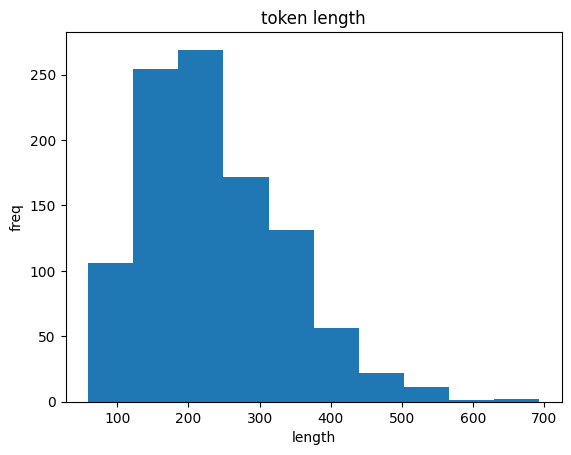

In [12]:
plt.hist(token_length_list)
plt.title('token length')
plt.xlabel('length')
plt.ylabel('freq')
plt.show()

## 5. 토큰 패딩

In [13]:
max_length = 300
front = False

train_pad_token = pad_token_tensor(train_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
valid_pad_token = pad_token_tensor(valid_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
test_pad_token = pad_token_tensor(test_tensor_token, max_length=max_length, cut_front=front, padding_token=0)

train_pad_token[0], train_pad_token.shape

(tensor([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,   6,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
          43,  22,  44,  26,  33,  45,  46,  47,  48,  49,  50,  51,  52,  53,
          54,  27,  55,  56,  57,  58,  33,  59,  60,  61,  62,  63,  64,  65,
          66,  67,  68,  69,  70,  41,  71,  72,  73,  63,  74,  75,  76,  77,
          78,  79,  41,  80,  81,  82,  83,  84,  85,  86,  87,  88,  67,  53,
          61,  62,  89,  90,  91,  92,  64,  67,  93,  94,  88,  49,  50,  95,
          53,  27,  55,  96,  97,  12,  98,  99, 100,  87,  88,  92,  53, 101,
         102,  16,  87,  68,  12,  98, 103, 104, 105, 106,  49,  50, 107, 108,
         109, 110, 111, 112, 113, 114, 115, 116,  61,  62, 117, 118, 119, 120,
         121,  33, 122, 123, 113, 114, 124, 125, 126,  61,  80, 127, 128, 117,
         118, 129,  73, 130, 131,  79, 132, 133, 134

In [14]:
train_labels2D = [[label] for label in train_labels]
valid_labels2D = [[label] for label in valid_labels]
test_labels2D = [[label] for label in test_labels]

train_labels2D[:5]

[[1], [4], [0], [1], [7]]

## 6. 커스텀 데이터셋 생성

In [15]:
trainDS = TextDataset(train_pad_token, train_labels2D)
validDS = TextDataset(valid_pad_token, valid_labels2D)

## 7. 모델, 옵티마이저 생성 및 훈련

### attempt3

In [ ]:
import requests
from bs4 import BeautifulSoup

# 크롤링할 뉴스 URL 설정
url = "https://news.naver.com/breakingnews/section/100/269"  # 실제 뉴스 링크로 변경하세요

# HTTP 요청 보내기
response = requests.get(url)
response.encoding = 'utf-8'  # 인코딩 설정

# HTML 파싱
soup = BeautifulSoup(response.text, 'html.parser')

soup.find_all('a', class_="sa_thumb_link _NLOG_IMPRESSION")

[<a class="sa_thumb_link _NLOG_IMPRESSION" data-clk="alist" data-gdid="880000C1_000000000000000000908722" data-imp-url="https://n.news.naver.com/mnews/article/088/0000908722" data-rank="1" href="https://n.news.naver.com/mnews/article/088/0000908722">
 <img alt="'체코 이어 필리핀' 원전 르네상스 시대 열리나…'K원전' 발빠른 성과" class="_LAZY_LOADING _LAZY_LOADING_INIT_HIDE" data-src="https://mimgnews.pstatic.net/image/origin/088/2024/10/09/908722.jpg?type=ofullfill220_150" height="75" onerror="this.outerHTML='&lt;span class=&quot;noimage&quot;&gt;&lt;/span&gt;'" style="display: none;" width="110"/>
 </a>,
 <a class="sa_thumb_link _NLOG_IMPRESSION" data-clk="alist" data-gdid="8822bt6d_000000000000000000053861" data-imp-url="https://n.news.naver.com/mnews/article/666/0000053861" data-rank="2" href="https://n.news.naver.com/mnews/article/666/0000053861">
 <img alt="인천시 투자유치대상 전 지역, 국내외 기업으로 확대" class="_LAZY_LOADING _LAZY_LOADING_INIT_HIDE" data-src="https://mimgnews.pstatic.net/image/origin/666/2024/10/09/53861.jpg?

In [19]:
batch_size = 16

trainDL = DataLoader(trainDS, batch_size = batch_size)
validDL = DataLoader(validDS, batch_size = batch_size)

n_vocab = len(voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 2
dropout = 0

model = SentenceClassifier(n_vocab, hidden_dim, embedding_dim, n_layers, output_size=8,
                           dropout=dropout, bidirectional=True, model_type='rnn')

adam = optim.Adam(model.parameters(), lr=0.001)
rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

EPOCH = 50
MODEL_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/TORCH_NLP/숙제/model_1009'

result = training(trainDL, validDL, model, model_type='multiclass', optimizer=adam,
                  epoch=EPOCH, endurance_cnt=5, view_epoch=1, num_classes=8, SAVE_PATH=MODEL_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/50] Train : 2.0965, Test : 2.0730
[Score  : 1/50] Train : 0.1191, Test : 0.1523
[Loss : 2/50] Train : 1.9614, Test : 2.0846
[Score  : 2/50] Train : 0.2520, Test : 0.1641
[Loss : 3/50] Train : 1.8160, Test : 2.1372
[Score  : 3/50] Train : 0.3047, Test : 0.1523
[Loss : 4/50] Train : 1.6732, Test : 2.2124
[Score  : 4/50] Train : 0.3428, Test : 0.1445
[Loss : 5/50] Train : 1.6046, Test : 2.2563
[Score  : 5/50] Train : 0.3662, Test : 0.1445
[Loss]값의 개선이 이루어지지 않아 [6] EPOCH에서 학습을 종료합니다.
